# Text Classification Slides - Kiva

Predict whether a Kiva loan application will default.

- Stephen W. Thomas
- Used for MMAI 891 and MMA/GMMA 865.
- The Simple and Easy Version.

# Preliminaries: Inspect and Set up environment

In [1]:
!which python

/usr/local/bin/python


In [2]:
!python --version

Python 3.6.9


In [3]:
!echo $PYTHONPATH

/env/python


In [4]:
pip install unidecode textstat

In [5]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
import pandas as pd
import numpy as np

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [7]:
import datetime
print(datetime.datetime.now())

2021-02-10 18:27:24.012542


# Read Data

In [8]:
kiva_df = pd.read_csv("https://raw.githubusercontent.com/stepthom/NLP_course/main/data/kiva_cleaned.csv")
kiva_df = kiva_df.dropna()
kiva_df = kiva_df.reset_index(drop=True)
kiva_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6802 entries, 0 to 6801
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   loan_id      6802 non-null   int64 
 1   status       6802 non-null   object
 2   sector       6802 non-null   object
 3   country      6802 non-null   object
 4   gender       6802 non-null   object
 5   loan_amount  6802 non-null   int64 
 6   nonpayment   6802 non-null   object
 7   en_clean     6802 non-null   object
dtypes: int64(2), object(6)
memory usage: 425.2+ KB


# EDA

In [9]:
kiva_df.head()

,loan_id,status,sector,country,gender,loan_amount,nonpayment,en_clean
0,0,defaulted,Agriculture,Kenya,M,500,lender,"Robert, 40, is married and has 6 children. In ..."
1,1,defaulted,Food,Kenya,F,500,lender,"Petronilla, 30, was deserted by her husband an..."
2,2,defaulted,Food,Kenya,M,500,lender,"Tom Mung'ahu, 45, is married and has 6 childre..."
3,3,defaulted,Services,Kenya,F,500,lender,"Benedina, 42, is married and has 4 girls. In a..."
4,4,defaulted,Construction,Kenya,M,500,lender,"Vincent Ondego 40, is married and has 8 childr..."


In [10]:
import spacy
from spacy import displacy
nlp = spacy.load("en_core_web_sm")

In [11]:
doc = nlp(kiva_df.iloc[5000].en_clean)
displacy.render(doc, style="ent", jupyter=True)

# Preprocessing

In [12]:
# The following code would be better off in a pipeline, to better support 
# train-test split, cross validation, and avoid leakage.
# However, since this is the "simple" version of the script, and there is
# little reason to believe leakage will actually occur, we'll keep it simple
# and perform the actions on the entire dataframe before splitting.

# Make some string columns 1/0
kiva_df['is_male'] = kiva_df['gender'].apply(lambda x: 1 if x == 'M' else 0)
kiva_df['is_nonpayment_lender'] = kiva_df['nonpayment'].apply(lambda x: 1 if x == 'lender' else 0)
kiva_df['defaulted'] = kiva_df['status'].apply(lambda x: 1 if x == 'defaulted' else 0)

# Easy way to One Hot Encode
kiva_df = pd.get_dummies(kiva_df, columns=['sector', 'country'])

# Drop columns we don't need/want any more.
kiva_df = kiva_df.drop(['status', 'gender', 'nonpayment', 'loan_id'], axis=1)

In [13]:
from nltk.stem import WordNetLemmatizer
import re
import unidecode

lemmer = WordNetLemmatizer()

# A nice preprocessing function that we can pass to CountVectorizer/TfidfVectorizer
def my_preprocess(doc):
    res = doc.lower()
    
    res = re.sub(r'[^\w\s]', '', res)
    
    res = unidecode.unidecode(res)

    res = ' '.join([lemmer.lemmatize(w) for w in res.split()])

    return res

# Train Test Split

In [14]:
from sklearn.model_selection import train_test_split

y = kiva_df['defaulted']
X = kiva_df.drop(['defaulted'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Feature Extraction

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from nltk.corpus import stopwords
import textstat

stop_words = [my_preprocess(x) for x in 
              set(stopwords.words('english') + stopwords.words('spanish'))]

vectorizer = TfidfVectorizer(preprocessor=my_preprocess,
                             stop_words = stop_words,
                             max_df = 0.5, 
                             min_df=0.05, 
                             max_features = 1000, 
                             ngram_range=[1,3])
#dtm = None

text_feature = 'en_clean'
drop_features = ['en_clean']

def fit_features(df):
  global dtm
  dtm = vectorizer.fit(df[text_feature])

  return

def transform_features(df):
  global dtm
 
  if dtm is None:
    print("Need to call fit_features first!")
    return

  dtm = vectorizer.transform(df[text_feature])

  features = pd.DataFrame(dtm.toarray(), 
                      columns=['bow_{:s}'.format(name) for name in 
                               vectorizer.get_feature_names()], 
                      index=df.index)
  
  passthrough_features = [c for c in df.columns if c not in drop_features]
  
  features[passthrough_features] = df[passthrough_features]

  features['len'] = df['en_clean'].apply(lambda x: len(x))
  features['syllable_count'] = df['en_clean'].apply(
        lambda x: textstat.syllable_count(x))
  features['flesch_reading_ease'] = df['en_clean'].apply(
      lambda x: textstat.flesch_reading_ease(x))
  
  return features



# Build Model

In [16]:
fit_features(X_train)
X_train_features = transform_features(X_train)

In [17]:
X_train_features.head()

,bow_10,bow_100,bow_12,bow_300,bow_able,bow_active,bow_active member,bow_activity,bow_add,bow_additional,bow_age,bow_ago,bow_allow,bow_also,bow_always,bow_amount,bow_another,bow_applied,bow_applied loan,bow_area,bow_attend,bow_back,bow_basic,bow_bean,bow_began,bow_belief,bow_better,bow_born,bow_bought,bow_boy,bow_business selling,bow_buy,bow_buying,bow_capital,bow_care,bow_cement,bow_child school,bow_childrens,bow_church,bow_city,...,bow_week,bow_well,bow_wholesale,bow_wife,bow_within,bow_woman,bow_woman group,bow_work,bow_working,bow_would,bow_would like,bow_year ago,bow_year experience,bow_year old,bow_year old married,bow_young,loan_amount,is_male,is_nonpayment_lender,sector_Agriculture,sector_Arts,sector_Clothing,sector_Construction,sector_Education,sector_Entertainment,sector_Food,sector_Health,sector_Housing,sector_Manufacturing,sector_Personal Use,sector_Retail,sector_Services,sector_Transportation,sector_Wholesale,country_Dominican Republic,country_Ecuador,country_Kenya,len,syllable_count,flesch_reading_ease
57,0.00000,0.146329,0.0,0.0,0.142018,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.099735,0.0,0.071245,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.064233,0.0,0.000000,0.0,0.0,0.275271,0.0,0.000000,0.0,...,0.0,0.103498,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.105693,0.0,0.068673,0.000000,0.000000,1500,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1686,417,64.64
1699,0.00000,0.000000,0.0,0.0,0.000000,0.133925,0.145826,0.000000,0.0,0.0,0.0,0.000000,0.0,0.074455,0.0,0.0,0.0,0.145113,0.153357,0.0,0.000000,0.0,0.000000,0.145349,0.0,0.152778,0.0,0.0,0.0,0.0,0.0,0.067127,0.0,0.000000,0.0,0.0,0.000000,0.0,0.134191,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.168504,0.126912,0.085856,0.0,0.205003,0.240199,0.000000,0.0,0.071767,0.114413,0.000000,600,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,776,183,85.28
1322,0.17227,0.000000,0.0,0.0,0.000000,0.170322,0.185458,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.184550,0.195035,0.0,0.000000,0.0,0.000000,0.184851,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.170660,0.0,...,0.0,0.000000,0.0,0.0,0.167484,0.107149,0.161404,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.091271,0.145508,0.000000,75,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,540,137,86.40
176,0.00000,0.000000,0.0,0.0,0.155195,0.140042,0.152487,0.150406,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.151372,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.117200,0.0,0.0,0.150406,0.0,0.140320,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.176200,0.265418,0.089777,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,200,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1235,315,68.30
1941,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.181885,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.081970,0.0,0.136863,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.456784,750,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,861,213,69.01


In [18]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=42)

clf.fit(X_train_features, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

# Assess Performance

In [19]:
X_test_features = transform_features(X_test)
y_pred_dt = clf.predict(X_test_features)

In [20]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred_dt)

array([[770,  87],
       [ 87, 757]])

In [21]:
from sklearn.metrics import classification_report

class_names = [str(x) for x in clf.classes_]

print(classification_report(y_test, y_pred_dt, target_names=class_names))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       857
           1       0.90      0.90      0.90       844

    accuracy                           0.90      1701
   macro avg       0.90      0.90      0.90      1701
weighted avg       0.90      0.90      0.90      1701



# Interpret Model

In [22]:
from sklearn.tree import export_text

feature_names = X_train_features.columns

print(export_text(clf, feature_names = list(feature_names)))

|--- is_nonpayment_lender <= 0.50
|   |--- bow_explains <= 0.12
|   |   |--- bow_requesting <= 0.05
|   |   |   |--- bow_entrepreneur <= 0.13
|   |   |   |   |--- bow_add <= 0.19
|   |   |   |   |   |--- bow_belief <= 0.13
|   |   |   |   |   |   |--- bow_allow <= 0.21
|   |   |   |   |   |   |   |--- bow_operates <= 0.13
|   |   |   |   |   |   |   |   |--- bow_nairobi <= 0.31
|   |   |   |   |   |   |   |   |   |--- bow_domingo <= 0.20
|   |   |   |   |   |   |   |   |   |   |--- bow_small <= 0.48
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 15
|   |   |   |   |   |   |   |   |   |   |--- bow_small >  0.48
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |--- bow_domingo >  0.20
|   |   |   |   |   |   |   |   |   |   |--- bow_community <= 0.21
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |   |--- bow_community >  0.21
|   |   |   |   |   |   

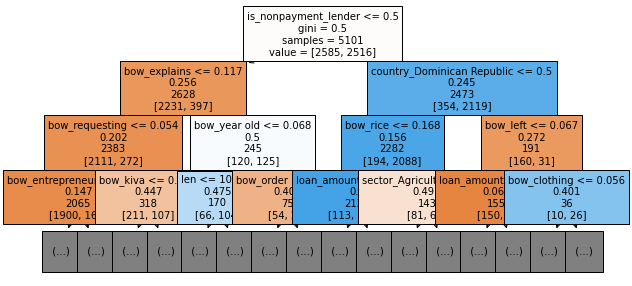

In [23]:
# Needs sklearn 0.21 or higher
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=[10,5]);
plot_tree(clf, filled=True, feature_names = feature_names, label='root', fontsize=10, max_depth=3)
plt.show();

In [24]:
feature_importances = None
if hasattr(clf, 'feature_importances_'):
    feature_importances = clf.feature_importances_

In [25]:
if feature_importances is None:
    print("No Feature importances! Skipping.")
else:

    features_train = X_train_features.to_numpy()  
    N = features_train.shape[1]

    ssum = np.zeros(N)
    avg = np.zeros(N)
    avg_1 = np.zeros(N)
    avg_0 = np.zeros(N)
    for i in range(N):
        ssum[i] = sum(features_train[:, i]).reshape(-1, 1)
        avg[i] = np.mean(features_train[:, i]).reshape(-1, 1)
        avg_1[i] = np.mean(features_train[y_train==1, i]).reshape(-1, 1)
        avg_0[i] = np.mean(features_train[y_train==0, i]).reshape(-1, 1)

    imp = pd.DataFrame(data={'feature': feature_names, 'imp': feature_importances, 'sum': ssum, 'avg': avg, 'avg_1': avg_1, 'avg_0': avg_0})
    imp = imp.sort_values(by='imp', ascending=False)
    imp.head(20)
    imp.tail(10)

,feature,imp,sum,avg,avg_1,avg_0
271,is_nonpayment_lender,0.497769,2.473000e+03,0.484807,0.842210,0.136944
287,country_Dominican Republic,0.078313,1.453000e+03,0.284846,0.143879,0.422050
73,bow_explains,0.028172,5.501273e+01,0.010785,0.011099,0.010479
196,bow_rice,0.027732,9.728599e+01,0.019072,0.012068,0.025889
269,loan_amount,0.023723,3.679085e+06,721.247795,649.344197,791.232108
290,len,0.022062,4.336209e+06,850.070378,882.944754,818.073501
45,bow_community,0.015448,2.113047e+02,0.041424,0.028053,0.054439
292,flesch_reading_ease,0.014410,3.649119e+05,71.537336,72.044360,71.043845
194,bow_requesting,0.014228,1.110578e+02,0.021772,0.031286,0.012511
127,bow_left,0.012810,5.142235e+01,0.010081,0.010671,0.009506


,feature,imp,sum,avg,avg_1,avg_0
177,bow_per,0.0,60.434717,0.011848,0.016417,0.007400
178,bow_period,0.0,57.902939,0.011351,0.018041,0.004840
179,bow_plan,0.0,118.386384,0.023208,0.021385,0.024983
71,bow_expense,0.0,51.320226,0.010061,0.011452,0.008707
182,bow_primary school,0.0,63.322099,0.012414,0.016611,0.008328
183,bow_produce,0.0,56.509850,0.011078,0.014965,0.007295
70,bow_expand business,0.0,111.442432,0.021847,0.029312,0.014582
188,bow_quality,0.0,59.022947,0.011571,0.010625,0.012491
65,bow_enough,0.0,88.847280,0.017418,0.019661,0.015234
208,bow_second,0.0,90.314506,0.017705,0.019524,0.015935


In [26]:
print(datetime.datetime.now())

2021-02-10 18:27:48.821152
